In [6]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [24]:
from math import pi

H = get_hamiltonian(L=6, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.2       +0.j,
 -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [25]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("111111")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [26]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

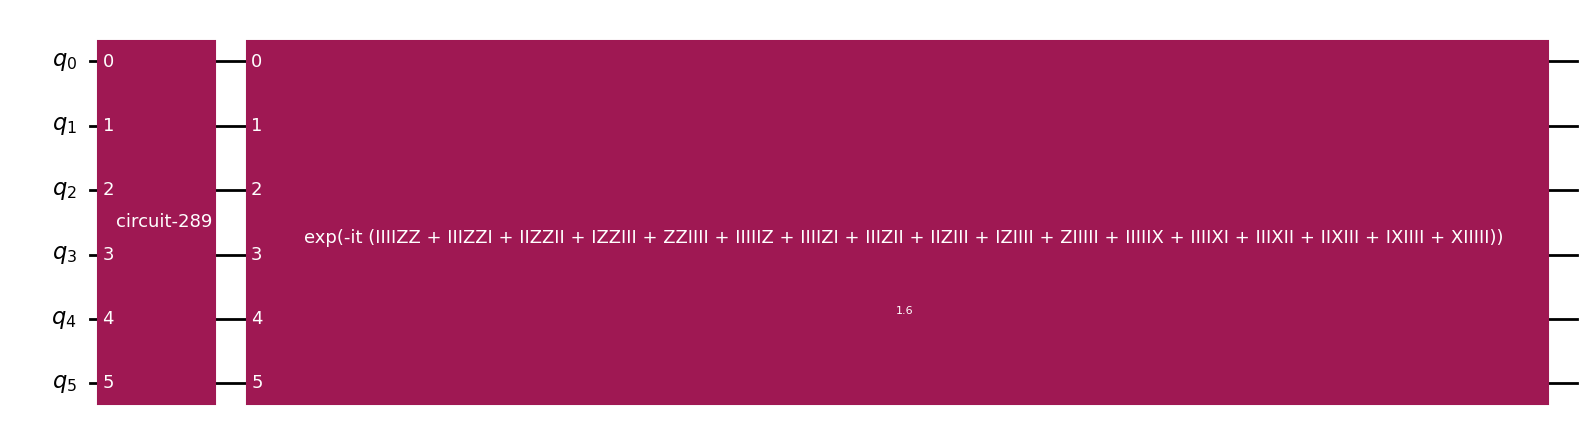

In [27]:
result.evolved_state.draw("mpl")

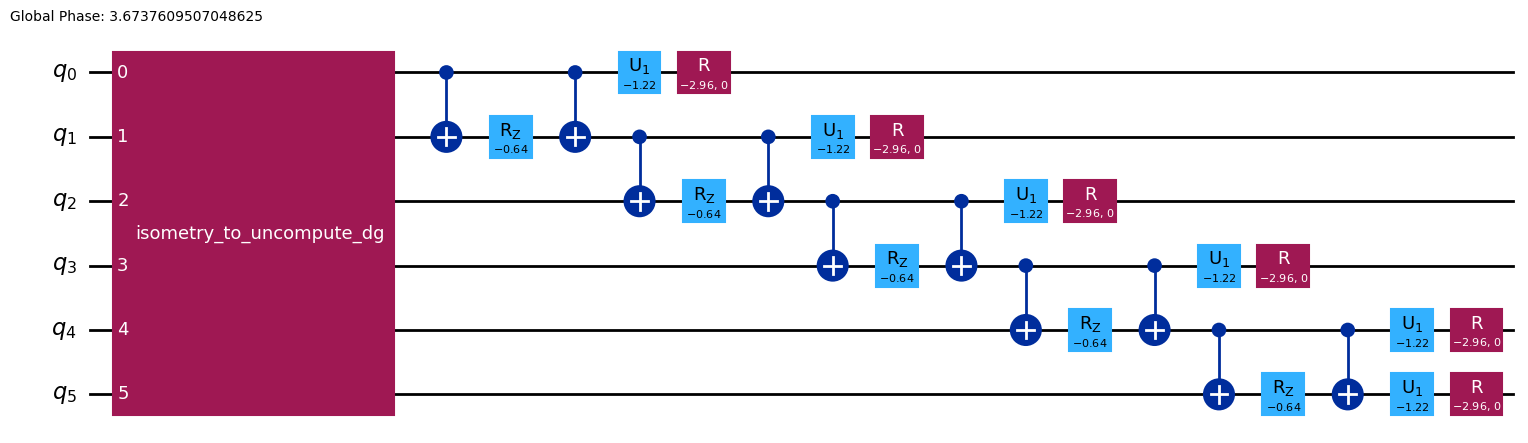

In [28]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

In [7]:
statevector = Statevector(result.evolved_state)
print(statevector)
Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))

Statevector([ 3.32529380e-07-5.28779215e-07j,
              5.69470344e-06+3.58118502e-06j,
              5.69470344e-06+3.58118502e-06j,
             -3.85676783e-05+6.13292775e-05j,
              5.69470344e-06+3.58118502e-06j,
             -3.85676783e-05+6.13292775e-05j,
             -3.85676783e-05+6.13292775e-05j,
             -6.60487473e-04-4.15355755e-04j,
              5.69470344e-06+3.58118502e-06j,
             -3.85676783e-05+6.13292775e-05j,
             -3.85676783e-05+6.13292775e-05j,
             -6.60487473e-04-4.15355755e-04j,
             -3.85676783e-05+6.13292775e-05j,
             -6.60487473e-04-4.15355755e-04j,
             -6.60487473e-04-4.15355755e-04j,
              4.47318612e-03-7.11313943e-03j,
              5.69470344e-06+3.58118502e-06j,
             -3.85676783e-05+6.13292775e-05j,
             -3.85676783e-05+6.13292775e-05j,
             -6.60487473e-04-4.15355755e-04j,
             -3.85676783e-05+6.13292775e-05j,
             -6.60487473e-04-4.153

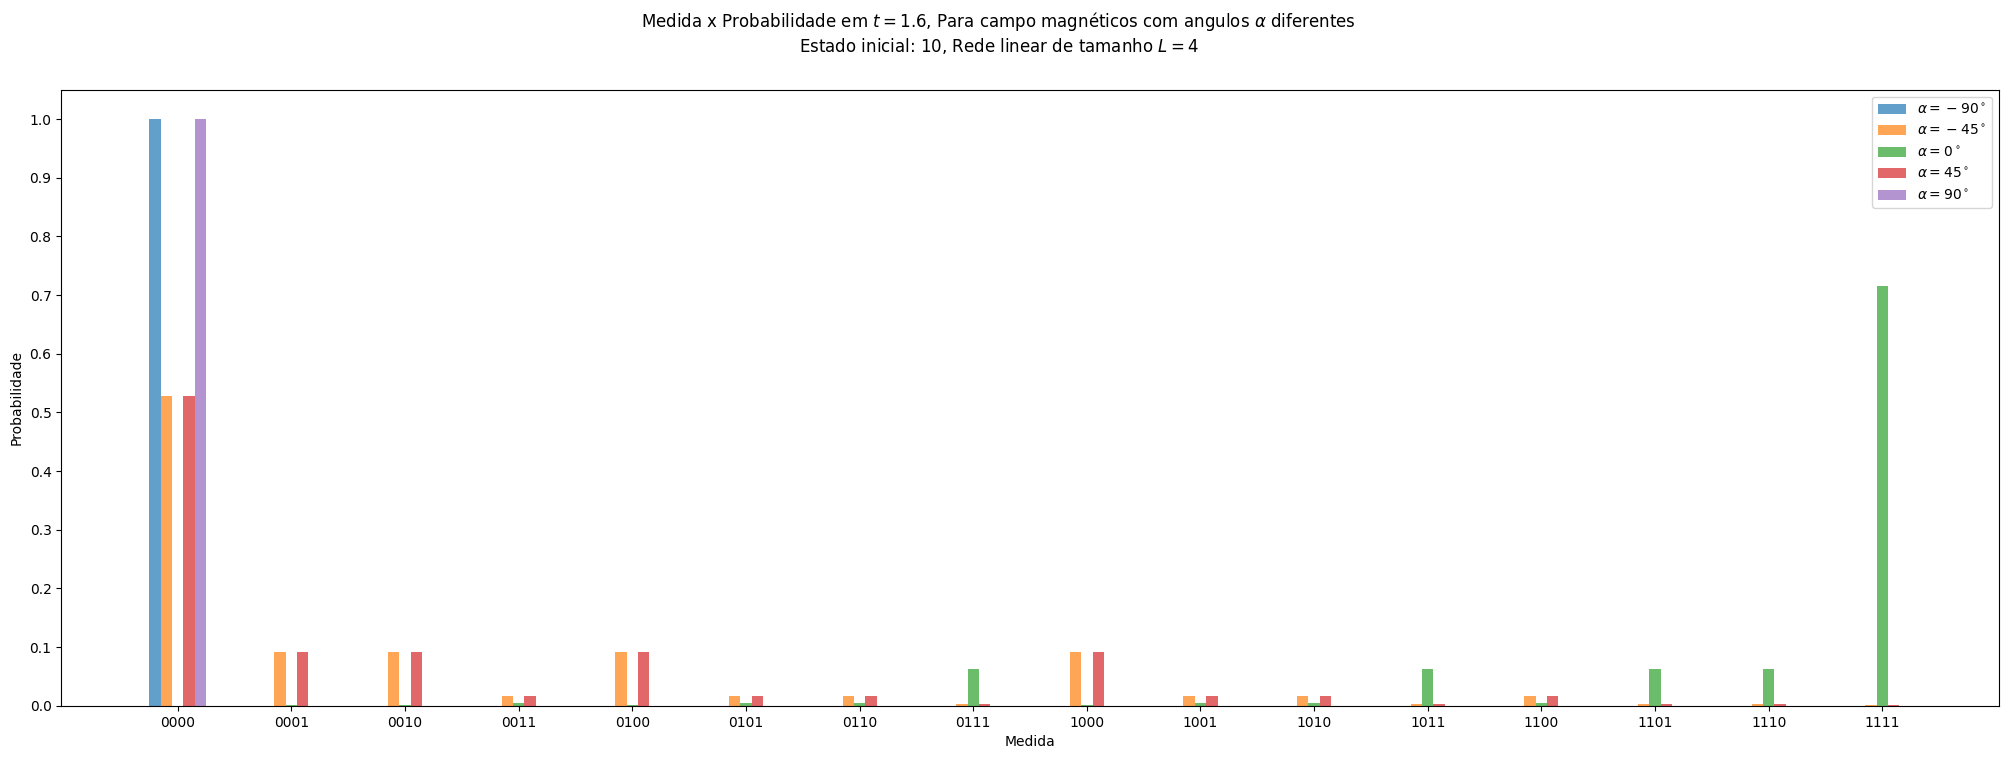

In [8]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("0000")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5
ELI = 4

plt.figure(figsize=(25, 8))
plt.yticks(np.arange(0, 1.1, 0.1))

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=ELI, J=0.2, h=1.0, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=5)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(pow(2,ELI)) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)


plt.xticks(np.arange(pow(2,ELI)) + 2 * bar_width, labels)
plt.xlabel("Medida")
plt.ylabel("Probabilidade")
plt.suptitle(
    f"Medida x Probabilidade em $t={final_time}$, Para campo magnéticos com angulos $\\alpha$ diferentes\n"
    f"Estado inicial: 10, Rede linear de tamanho $L={ELI}$"
)
plt.legend()

-

In [28]:
from math import pi

L = 11
H = get_hamiltonian(L=L, J=0.2, h=1.2, alpha=pi / 8)

In [29]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

C:\Users\bolar\AppData\Local\Temp\ipykernel_3212\2834281491.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


In [30]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)


In [44]:
final_time = 100.0
initial_state = Statevector.from_label("00000100000")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)

In [45]:
result = trotter.evolve(problem)

In [33]:
observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

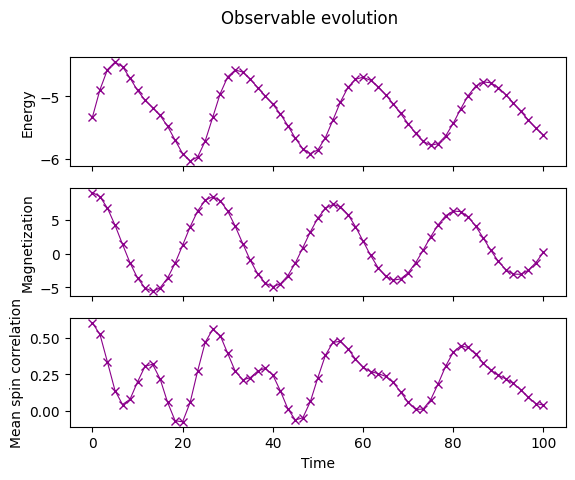

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

-

In [47]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [
    initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
]

In [48]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

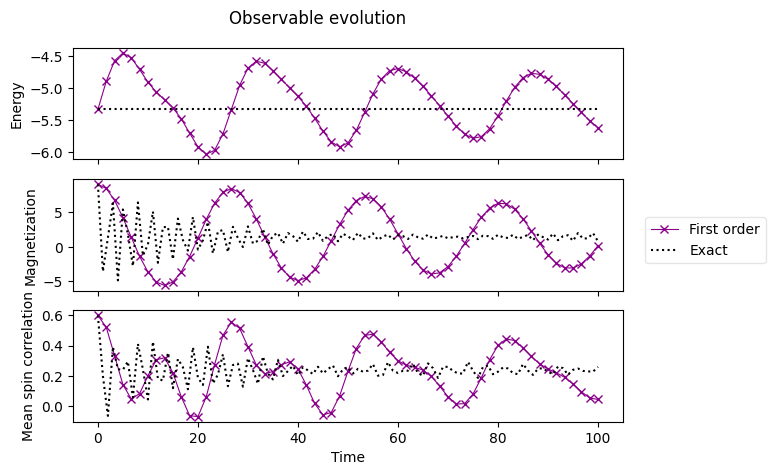

In [49]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

-


Trotter step with Lie-Trotter
-----------------------------

Depth: 32
Gate count: 52
Nonlocal gate count: 20
Gate breakdown: CX: 20, U1: 11, R: 11, RZ: 10



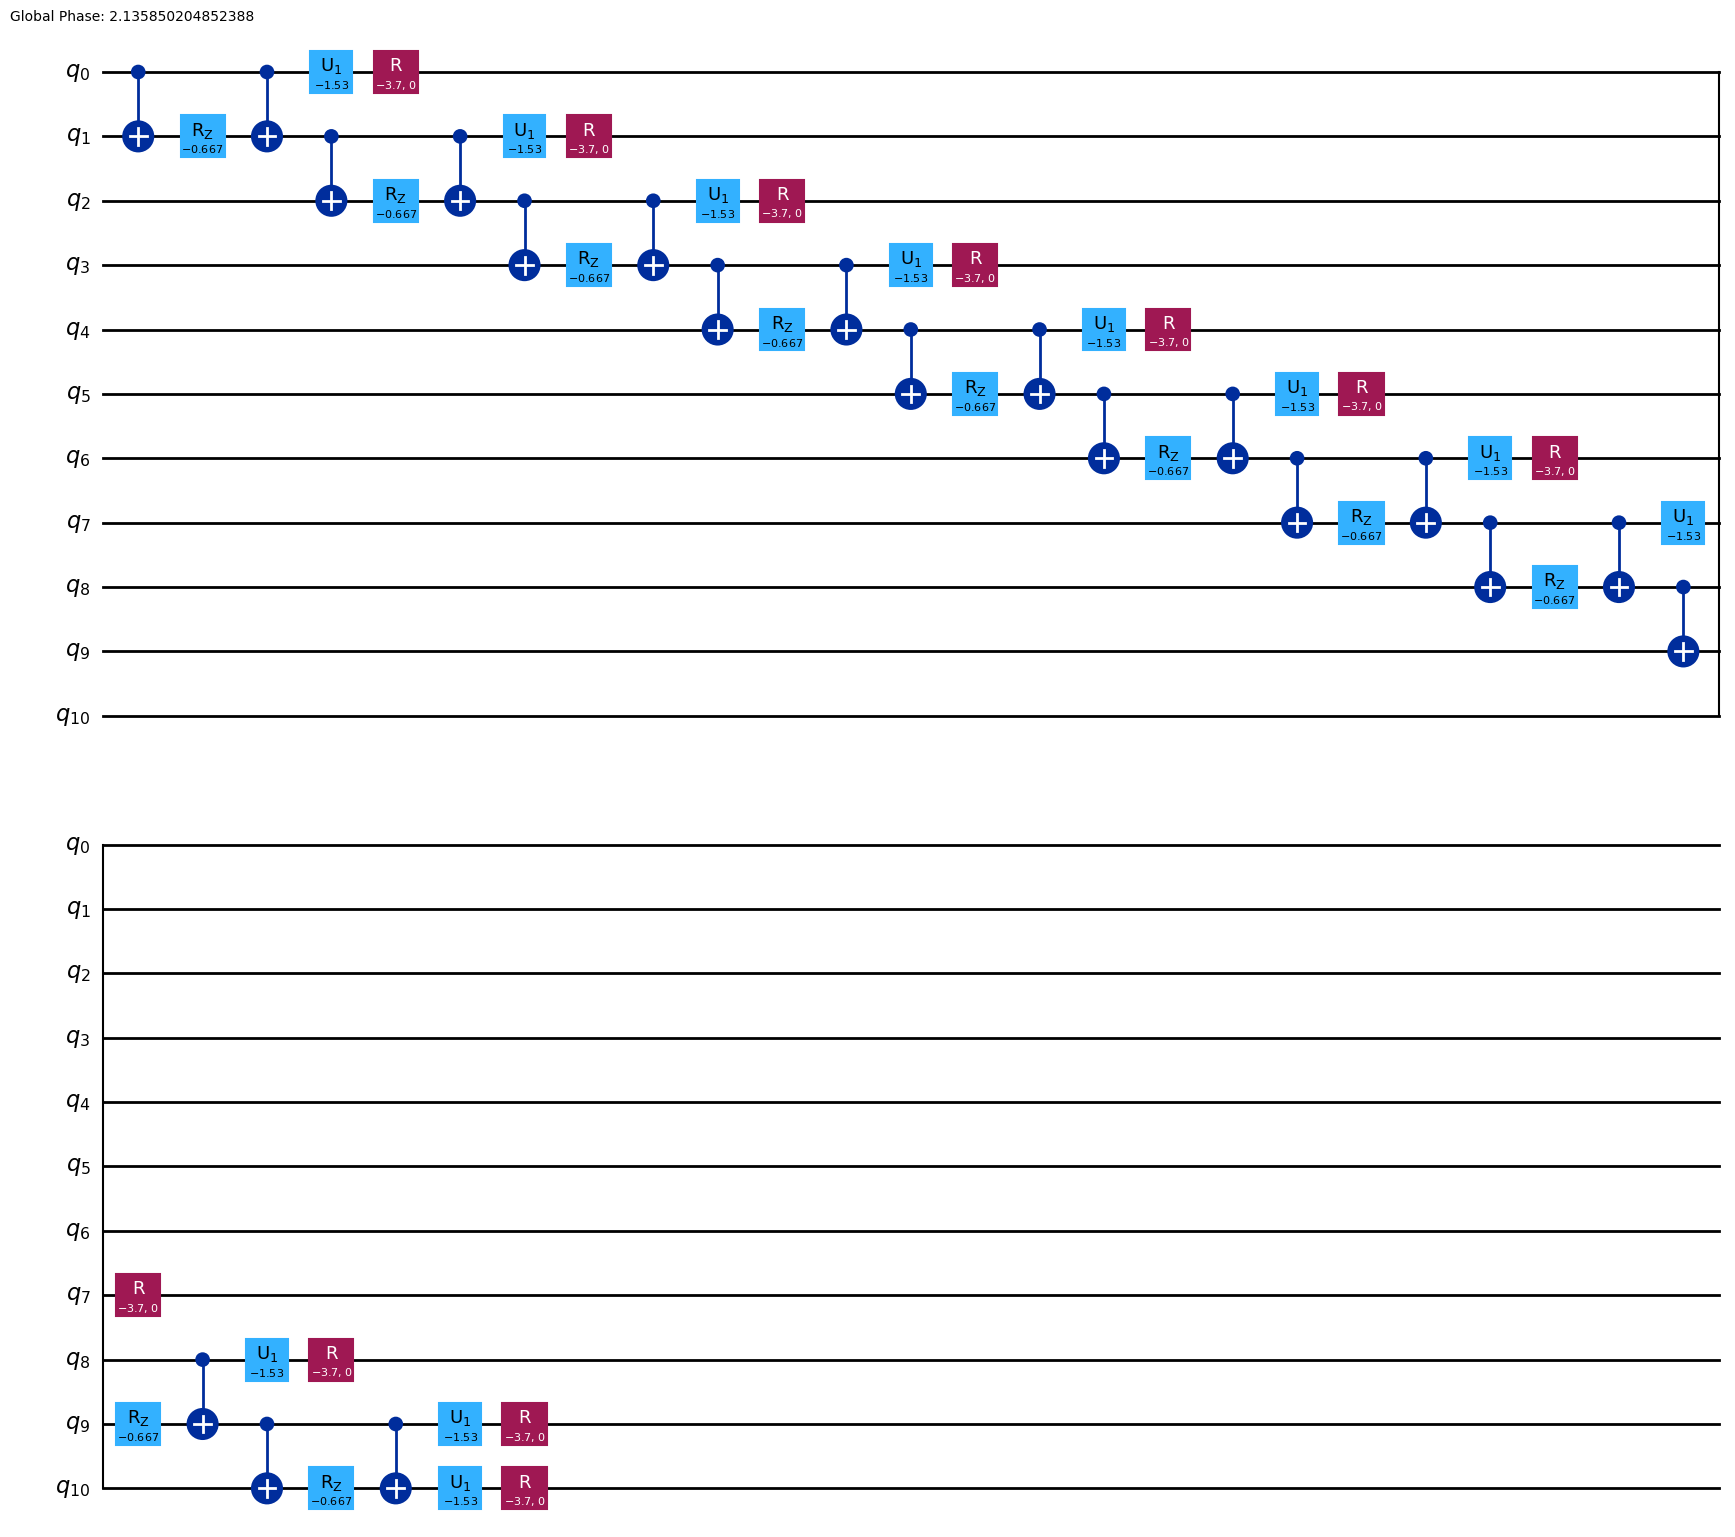

In [50]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------

Depth: {circuit.depth()}
Gate count: {len(circuit)}
Nonlocal gate count: {circuit.num_nonlocal_gates()}
Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)

# And finally draw the circuit
circuit.draw("mpl")




-


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 64
             Gate count: 103
    Nonlocal gate count: 40
         Gate breakdown: CX: 40, U1: 22, R: 21, RZ: 20




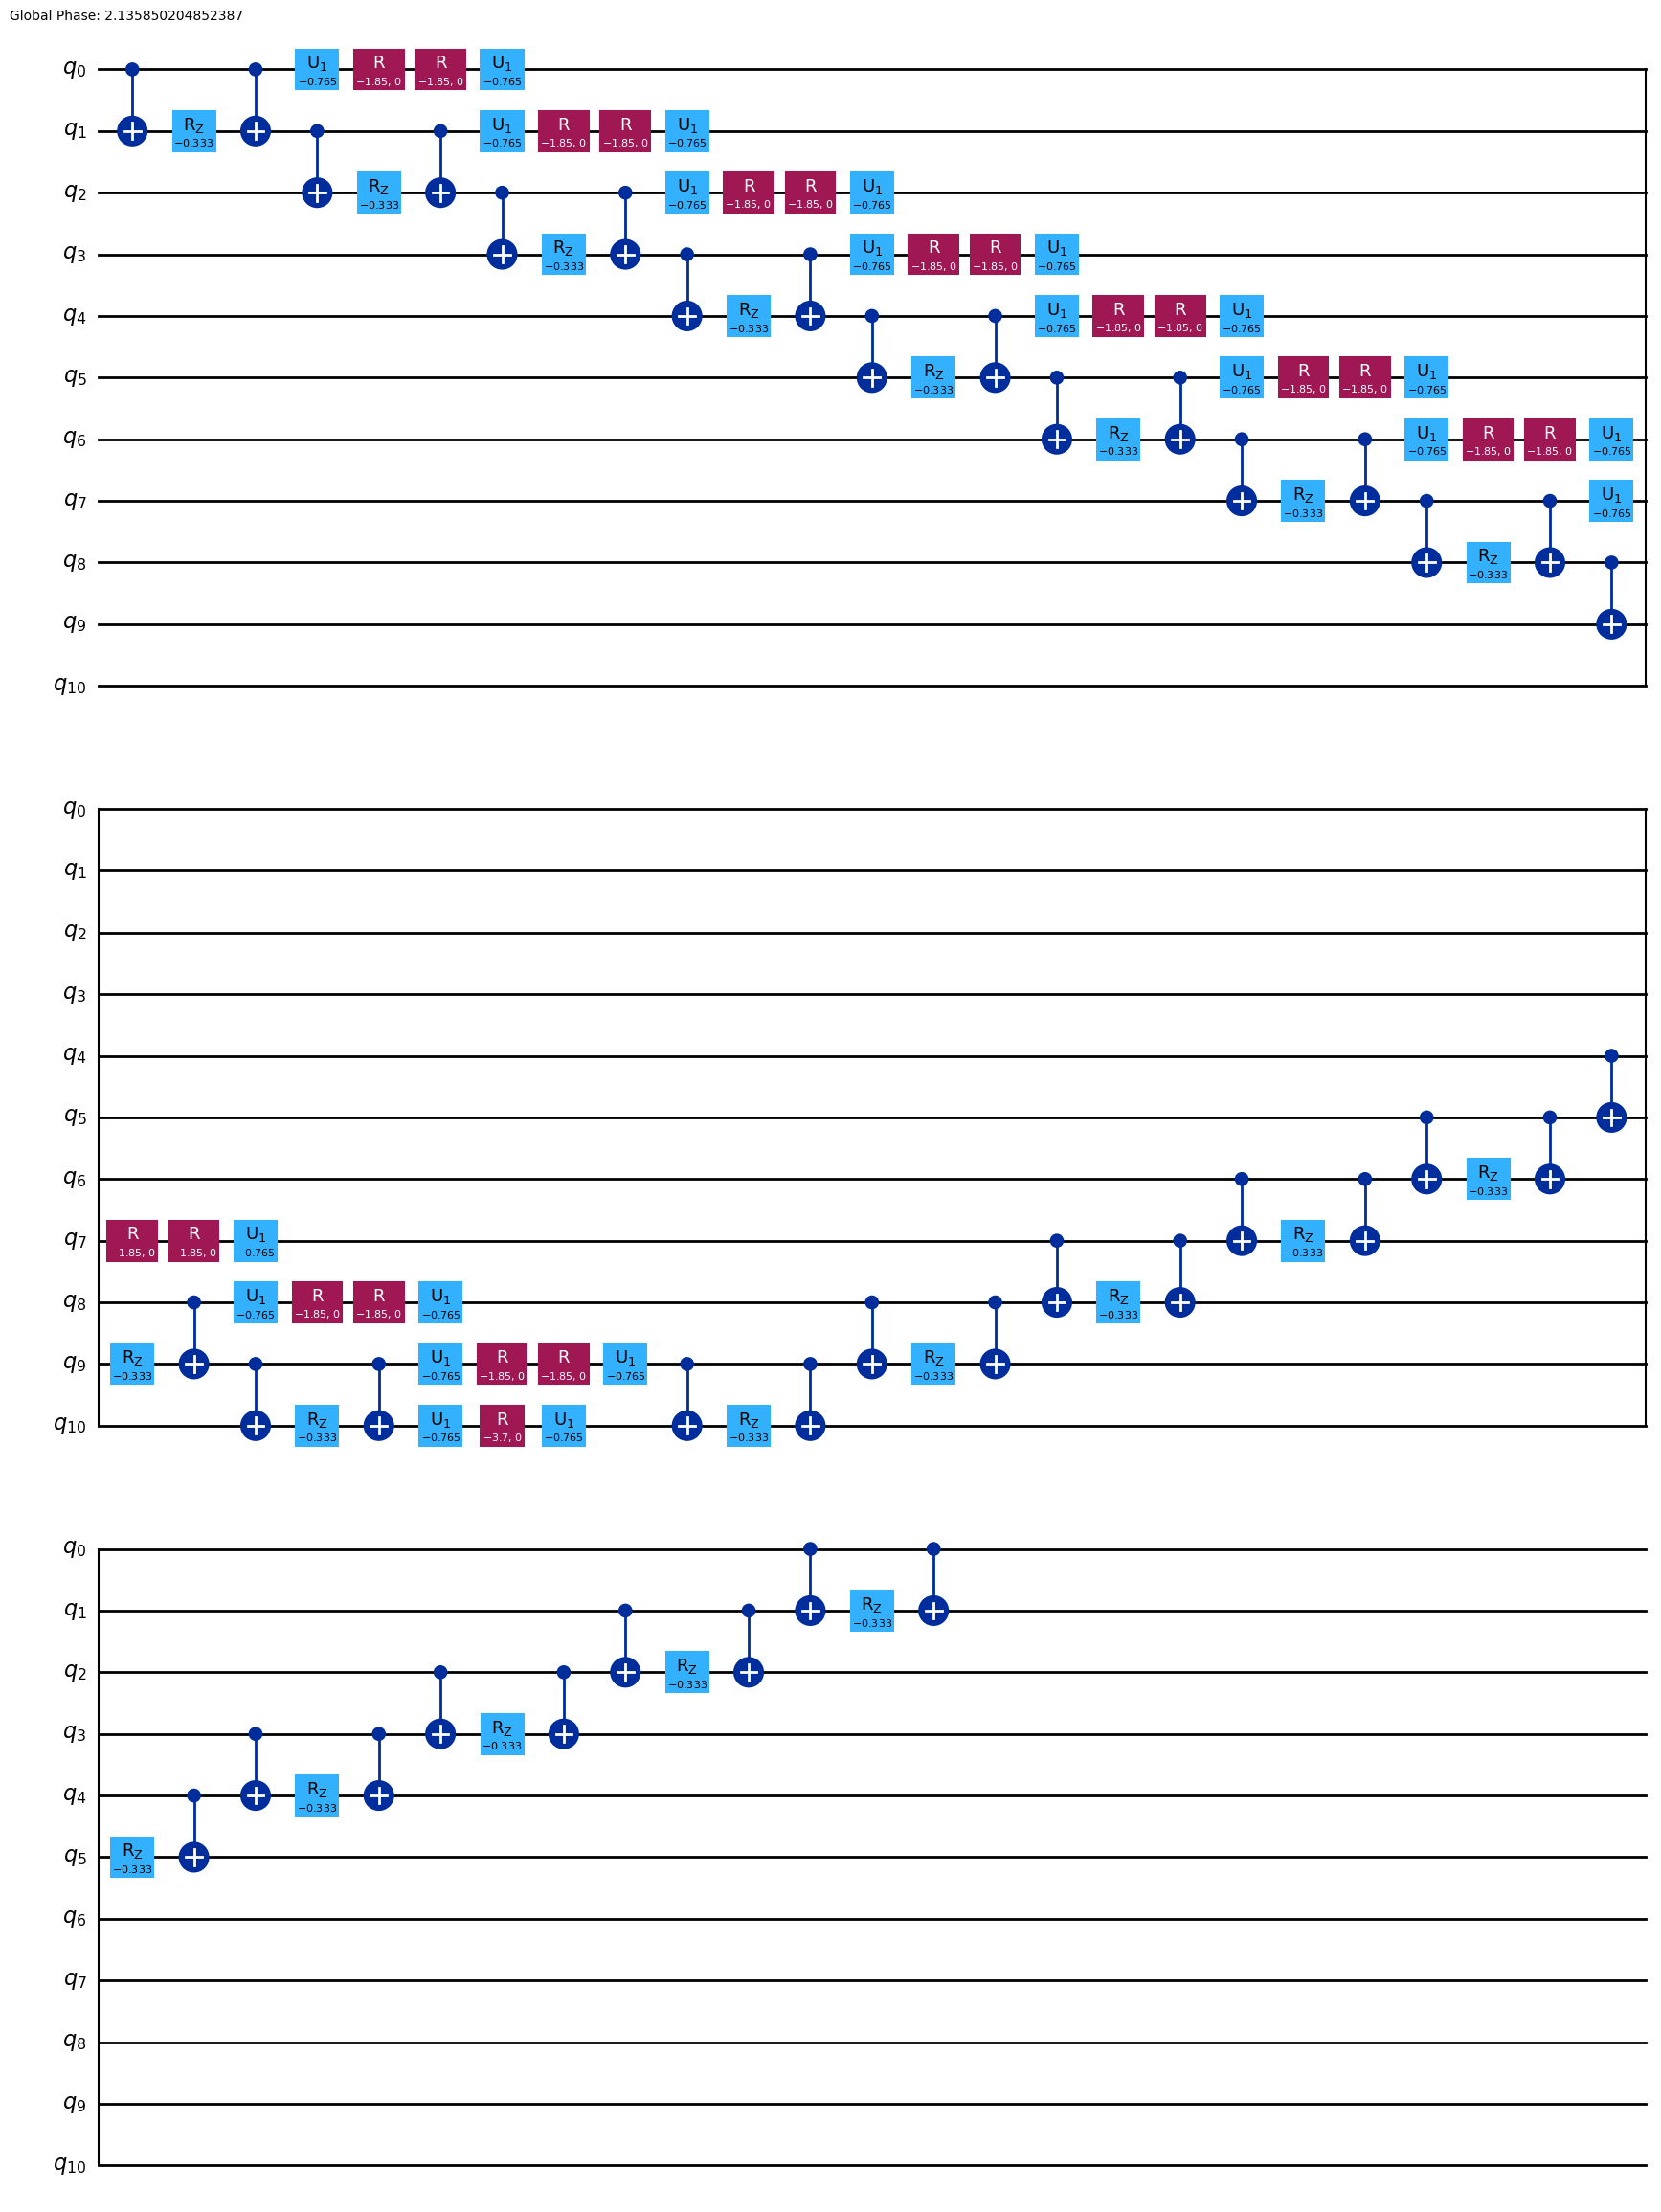

In [51]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

# And finall
circuit.draw("mpl")

In [52]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 320
             Gate count: 515
    Nonlocal gate count: 200
         Gate breakdown: CX: 200, U1: 110, R: 105, RZ: 100




In [53]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)


C:\Users\bolar\AppData\Local\Temp\ipykernel_3212\987677301.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())


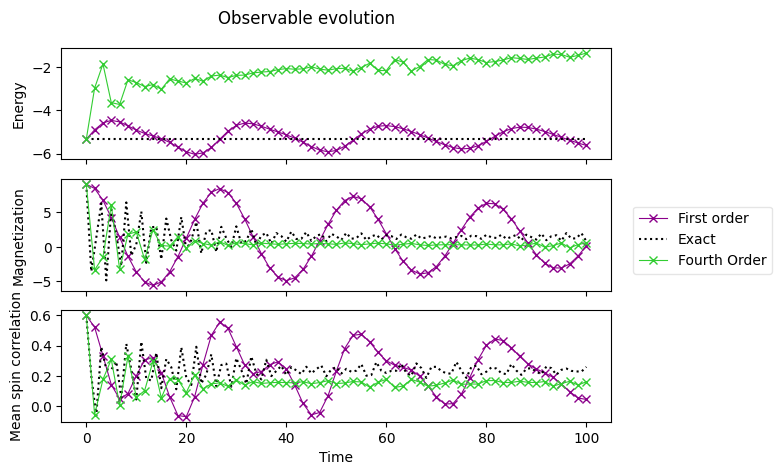

In [54]:
axes[0].plot(
    times, observables_order4[:, 0], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[1].plot(
    times, observables_order4[:, 1], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[2].plot(
    times, observables_order4[:, 2], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)

# Replace the legend
legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

-

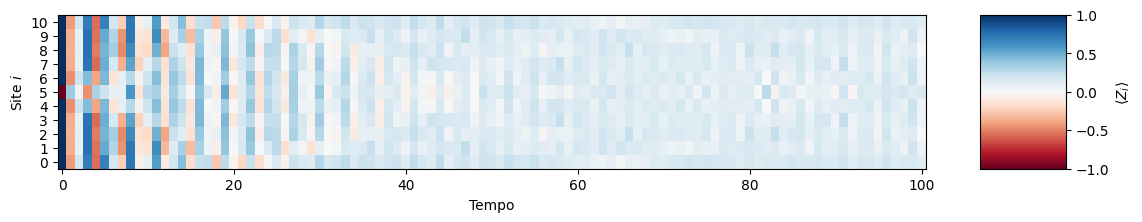

In [55]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real(
    [[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution]
)
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap="RdBu")
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel("Site $i$")
plt.xlabel("Tempo")
plt.colorbar(label="$\\langle Z_i \\rangle$", aspect=1.8)